In [8]:
import time
import os
from io import open
import pysmu
from pysmu import Mode
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats

import pickle 

In [3]:
session = pysmu.Session(ignore_dataflow=True)

In [4]:
smu = session.devices[0]

# Links 

[Nice stackexhcange answer on how dynamos work electrically](https://electronics.stackexchange.com/questions/498144/in-a-shimano-dynamo-hub-with-6v-regulator-is-the-rest-of-the-power-being-wasted)

[A really in depth look at getting the most out of a dynamo](http://pilom.com/BicycleElectronics/DynamoCircuits.htm)

Maybe I should just permanently use a voltage doubler?

In [5]:
CHA = smu.channels['A']
CHB = smu.channels['B']

# CHAN_A source
CHA.mode = Mode.HI_Z
# chan_a.mode = Mode.SVMI
#chan_a.mode = Mode.SVMI_SPLIT
#chan_a.mode = Mode.SIMV
# CHAN_B source
CHB.mode = Mode.HI_Z
# chan_b.mode = Mode.SVMI
#chan_b.mode = Mode.SIMV
#chan_b.mode = Mode.SIMV_SPLIT

In [6]:
f"{smu.sample_rate/1e3}kHz"

'100.0kHz'

In [7]:
session.configure(1000)
f"Sample rate: {smu.sample_rate/1e3}kHz"

'Sample rate: 1.0kHz'

sample rate 10.0kHz samples: 150000 time: 15s


(<Figure size 720x360 with 4 Axes>,
 (<AxesSubplot:ylabel='Voltage (V)'>, <AxesSubplot:ylabel='Current (mA)'>))

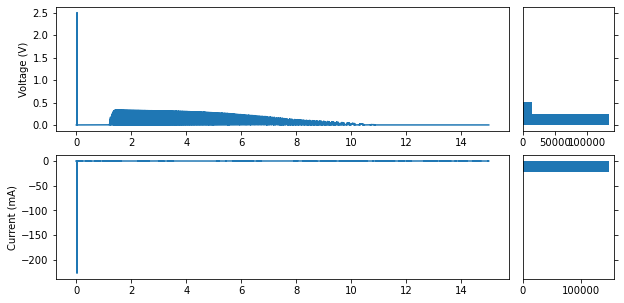

In [19]:
def plot_samples(t,V,I, Vlim = None, Ilim = None, tlim = None):
    I = 1000*I #convert to mA

    f, ((axV, histV), (axI, histI)) = plt.subplots(
        figsize = (10,5),
        ncols = 2, nrows = 2, 
        sharey = "row",
        gridspec_kw = dict(
            width_ratios = (5,1),
            wspace = 0.05,
        )
    )
    axV.plot(t,V)
    axI.plot(t,I)

    histI.hist(I, orientation = "horizontal")
    histV.hist(V, orientation = "horizontal")
    set_right(histI)
    set_right(histV)

    axI.set(ylabel = "Current (mA)", ylim = Ilim, xlim = tlim)
    axV.set(ylabel = "Voltage (V)", ylim = Vlim, xlim = tlim)
    
    return f, (axV, axI)

def set_right(ax):
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
session.configure(sample_rate = int(10e3))
    
sample_time = 15 # seconds
samples = int(smu.sample_rate * sample_time)
t = np.linspace(0, sample_time, samples)

print(f"sample rate {smu.sample_rate/1e3}kHz samples: {samples} time: {sample_time}s")

# CHA.mode = Mode.SVMI
# CHA.mode = Mode.SVIMV_SPLIT
# CHA.constant(value = 1)
(VA, VB), (IA, IB) = np.array(smu.get_samples(samples)).T

plot_samples(t, VA,IA)

# from scipy.fft import fft, ifft, fftfreq
# ft = fft(I)
# ft_freqs = fftfreq(samples, 1/smu.sample_rate)

# f, ax = plt.subplots()
# ax.plot(ft_freqs, np.abs(ft))
# ax.set(yscale = 'log', xlim = (0, 5000))
# ax.axvline(1200, linestyle = 'dotted')

In [20]:
data = dict(
    voltage = VA,
    time = t,
    sample_rate = 10e3,
    revolutions = 15,
    potential_divider = (10,1),
    load = 5,
)

# with open("bike_generator_data_5ohm_load.pickle", "bw") as f:
#     pickle.dump(data, f)

In [266]:
different_loads = {}

with open("bike_generator_data.pickle", "br") as f:
    different_loads[np.inf] = pickle.load(f)
    
with open("bike_generator_data_20ohm_load.pickle", "br") as f:
    different_loads[20] = pickle.load(f)
    
with open("bike_generator_data_10ohm_load.pickle", "br") as f:
    different_loads[10] = pickle.load(f)

with open("bike_generator_data_5ohm_load.pickle", "br") as f:
    different_loads[5] = pickle.load(f)
    
different_loads.keys()

dict_keys([inf, 20, 10, 5])

[(5.0, 6.0)]

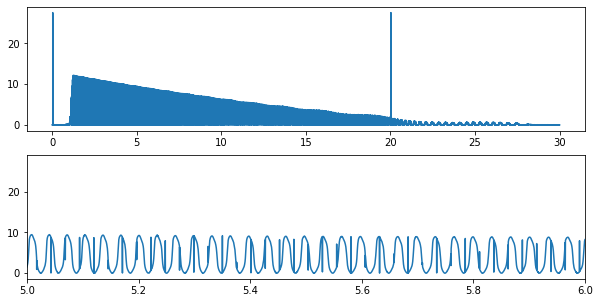

In [267]:
with open("bike_generator_data.pickle", "br") as f:
    data = pickle.load(f)

f, (axA, axB) = plt.subplots(
    figsize = (10,5),
    ncols = 1, nrows = 2,
)

Ra, Rb = data["potential_divider"]

axA.plot(data['time'], data["voltage"] * (Ra + Rb) / Rb)
axB.plot(data['time'], data["voltage"] * (Ra + Rb) / Rb)

axB.set(xlim = (5,6))

[(0.0, 6.0)]

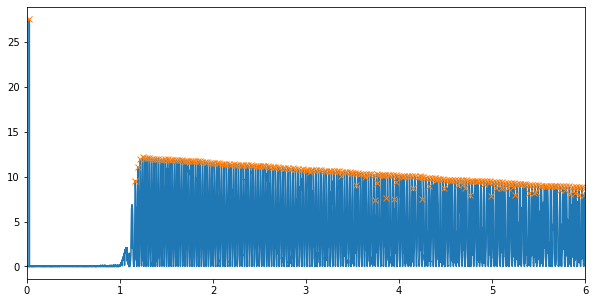

In [268]:
with open("bike_generator_data.pickle", "br") as f:
    data = pickle.load(f)

f, ax = plt.subplots(figsize = (10,5))

Ra, Rb = data["potential_divider"]

V = data["voltage"] * (Ra + Rb) / Rb
t = data["time"]
ax.plot(t,V)

peaks, properties = scipy.signal.find_peaks(V, prominence = 7)
# cwt_peaks, properties = scipy.signal.find_peaks_cwt(V, np.linspace(1e3, 1e4, 3))

ax.plot(t[peaks], V[peaks], "x")


ax.set(xlim = (0,6))

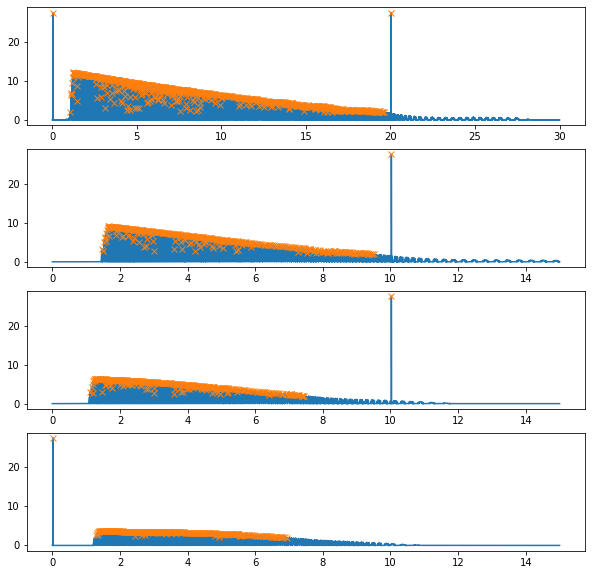

In [269]:
import scipy.signal

f, axes = plt.subplots(nrows = len(different_loads), figsize = (10,10))

for (load, d), ax in zip(different_loads.items(), axes):
    # print(d)
    Ra, Rb = d["potential_divider"]
    V = d["voltage"] * (Ra + Rb) / Rb
    t = d["time"]
    
    peaks, properties = scipy.signal.find_peaks(V, prominence = 2)

    l, = ax.plot(t,V)
    ax.plot(t[peaks], V[peaks], "x", label = f"R = {load}")
    
# ax.set(
#     xlim = (0, 100),
#     ylim = (None, 14),
#     xlabel = "Frequency [Hz]", ylabel = "Amplitude [V]")
# ax.legend()

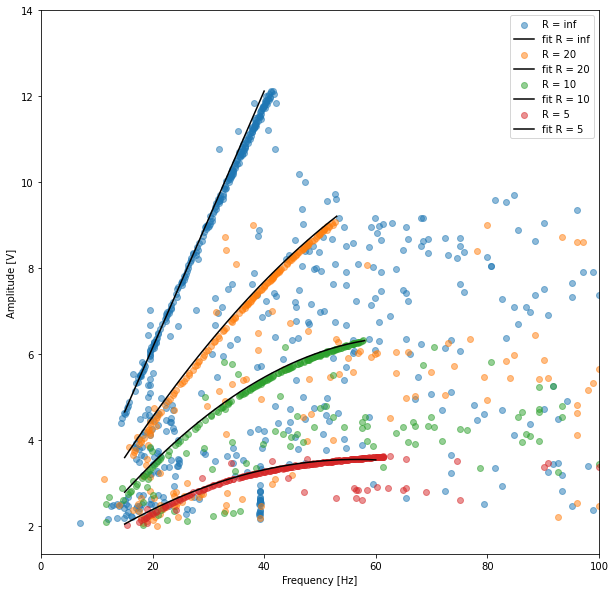

In [301]:
import scipy.signal

f, ax = plt.subplots(figsize = (10,10))

fits = {}

prominances = [2, 2, 2, 2]
fit_ranges = ([15,40], [15,53], [15,58], [15,60])

for (load, d), p, fit_range in zip(different_loads.items(), prominances, fit_ranges):
    # print(d)
    Ra, Rb = d["potential_divider"]
    V = d["voltage"] * (Ra + Rb) / Rb
    t = d["time"]
    
    index_distance = (1/100) / (1/d["sample_rate"])
    
    peaks, properties = scipy.signal.find_peaks(V,
                                                prominence = p,
                                               distance = index_distance)
    time_periods = t[peaks[1:]] - t[peaks[:-1]]
    amplitudes = (V[peaks[:-1]] + V[peaks[1:]]) / 2
    freq = 1/time_periods

    ax.scatter(freq, amplitudes, alpha = 0.5, label = f"R = {load}")
    
    def quantile(upper, lower):
        def _f(x): 
            high_limit = np.quantile(x, upper, method = "higher")
            low_limit = np.quantile(x, lower, method = "lower")
            return np.median(x[(low_limit <= x) & (x <= high_limit) ])
        return _f
    
    def tmean(p): 
        def _f(x):
            return scipy.stats.trim_mean(x, p)
        return _f
        
    bins = np.linspace(*fit_range, 30)
    # upper, _, _ = scipy.stats.binned_statistic(freq, amplitudes,
    #                                       statistic=quantile(0.9), bins = bins)
    # lower, _, _ = scipy.stats.binned_statistic(freq, amplitudes,
    #                                       statistic=quantile(0.6), bins = bins)
    
    mid, _, _ = scipy.stats.binned_statistic(freq, amplitudes,
                                      statistic=quantile(0.95,0.6), bins = bins)
    
    # ax.plot(bins[:-1], upper, color = 'k', label = f"fit R = {load}")
    # ax.plot(bins[:-1], lower, color = 'k', label = f"fit R = {load}")
    # ax.plot(bins[:-1], mid, color = 'k', label = f"fit R = {load}", alpha = 0.5)
    
    from numpy.polynomial import Polynomial
    degree = 1 if load == np.inf else 2
    # degree = 2
    c = Polynomial.fit(bins[:-1], mid, deg=degree)
    fits[load] = c
    ax.plot(bins, c(bins), color = 'k', label = f"fit R = {load}")
    
ax.set(
    xlim = (0, 100),
    ylim = (None, 14),
    xlabel = "Frequency [Hz]", ylabel = "Amplitude [V]")
ax.legend()

I want some kind of model of the underlying process here, after a reading around a bit and specifically some comments on this [stack overflow post][post], I tried modelling the generator as a Variable voltage source in series with an inductor and a resistor. This is essentially a slightly restricted [Thévenin equivalent circuit][thevenin] with a frequency dependent voltage. 

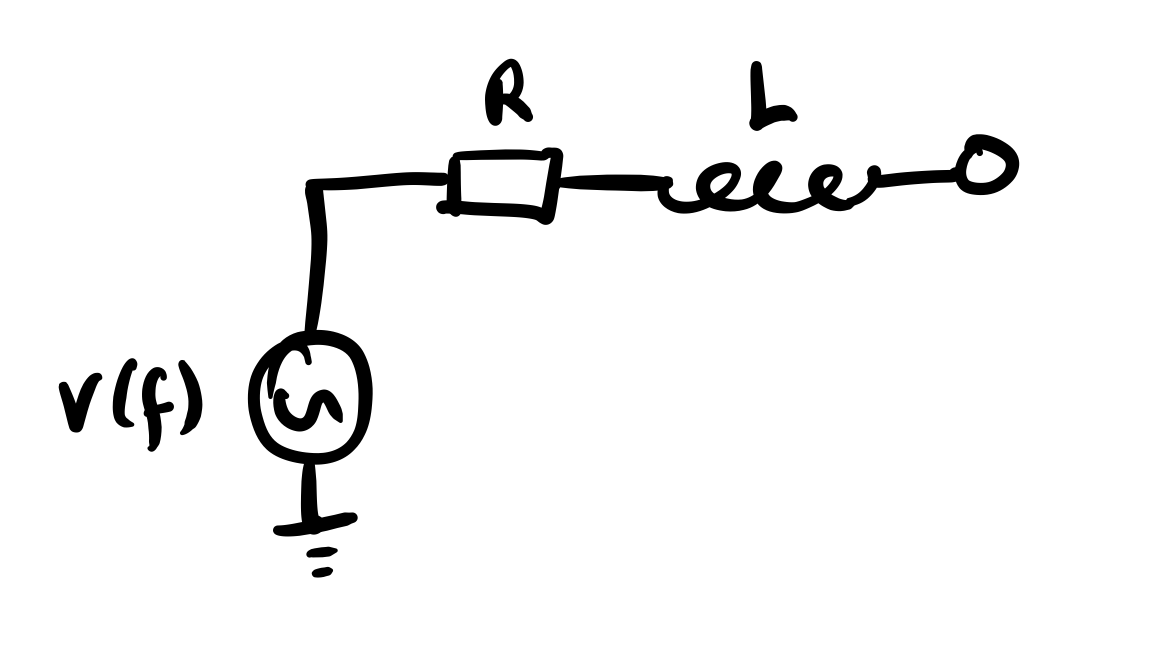

In the spirit of going for the simplest thing that could work, I modelled the voltage as just being a constant times the frequency. That's physically reasonable, there should be no voltage when the frequency is zero after all. 

[thevenin]: https://en.wikipedia.org/wiki/Th%C3%A9venin%27s_theorem
[post]: https://electronics.stackexchange.com/questions/498144/in-a-shimano-dynamo-hub-with-6v-regulator-is-the-rest-of-the-power-being-wasted


Thevin Source Model
Series Inductance: 60 mH
Series Resistance : 5.9 Ohm
Volts per Hz: 0.3 V / Hz

Time constant of RL system: 10ms / 98Hz




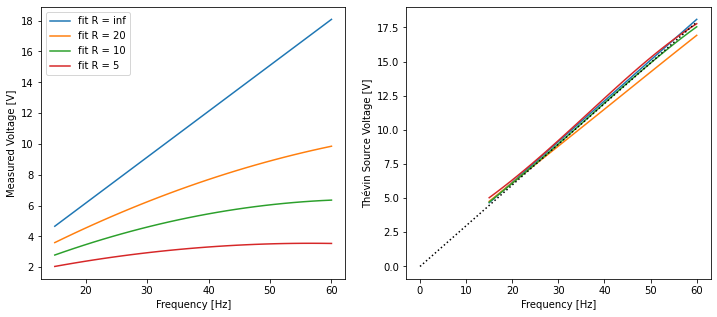

In [302]:
f = bins
omega = 2*np.pi*f

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12,5))

def model(R, L, omega, Vout, load): 
    Z = 1j * omega * L + R
    return abs((Z + load) / (load)) * Vout if load != np.inf else Vout

def loss(x):
    R, L, volts_per_Hz = x
    # R, L = x
    collapsed = np.array([model(R, L, omega, fit(f), load) for fit, load in zip(fits.values(), different_loads.keys())])
    V = volts_per_Hz * omega / (2*np.pi)
    # stds = np.std(collapsed, axis = 0)
    mean_squared_distances = np.mean((collapsed - V)**2)
    return mean_squared_distances

result = scipy.optimize.minimize(loss, x0 = [1,0.01,12/40])
R, L, volts_per_Hz = result.x

for (load, d), fit in zip(different_loads.items(), fits.values()):
    f = bins
    Vout = fit(bins)
    ax.plot(f, Vout, label = f"fit R = {load}")
    
    # R = 7
    # L = 0.04
    V = model(R, L, omega, Vout, load)
    ax2.plot(f, V)
    
f2 = np.linspace(0,60,10)
ax2.plot(f2, volts_per_Hz * f2, linestyle = "dotted", color = "k")
    
ax.set(xlabel = "Frequency [Hz]", ylabel = "Measured Voltage [V]")
ax2.set(xlabel = "Frequency [Hz]", ylabel = "Thévin Source Voltage [V]")
# ax2.set(xlim = (0,65), ylim = (0,17))
    
ax.legend()
print(f"""
Thevin Source Model
Series Inductance: {L*1000:.0f} mH
Series Resistance : {R:.1f} Ohm
Volts per Hz: {volts_per_Hz:.2} V / Hz

Time constant of RL system: {1e3*L/R:.0f}ms / {R/L:.0f}Hz

""")

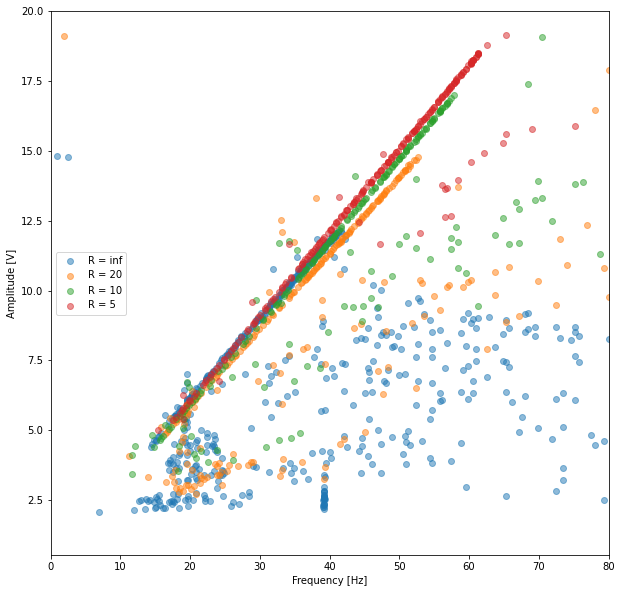

In [312]:
import scipy.signal

f, ax = plt.subplots(figsize = (10,10))

fits = {}

prominances = [2, 2, 2, 2]
fit_ranges = ([15,40], [15,53], [15,58], [15,60])

for (load, d), p, fit_range in zip(different_loads.items(), prominances, fit_ranges):
    # print(d)
    Ra, Rb = d["potential_divider"]
    V = d["voltage"] * (Ra + Rb) / Rb
    t = d["time"]
    
    index_distance = (1/100) / (1/d["sample_rate"])
    
    peaks, properties = scipy.signal.find_peaks(V,
                                                prominence = p,
                                               distance = index_distance)
    time_periods = t[peaks[1:]] - t[peaks[:-1]]
    amplitudes = (V[peaks[:-1]] + V[peaks[1:]]) / 2
    freq = 1/time_periods

    
    
    omega = 2*np.pi*freq
    collapsed = model(R, L, omega, amplitudes, load)
    ax.scatter(freq, collapsed, alpha = 0.5, label = f"R = {load}")

    

    
ax.set(
    xlim = (0, 80),
    ylim = (None, 20),
    xlabel = "Frequency [Hz]", ylabel = "Amplitude [V]")
ax.legend()

In [313]:
from scipy import signal
Ra, Rb = data["potential_divider"]
Sf, St, Sxx = signal.spectrogram(data["voltage"] * (Ra + Rb) / Rb,
                                 fs = data["sample_rate"],
                                 window = "blackman",
                                nperseg = 2**14,
                                noverlap = 2**13,
                                nfft = 2**14, #optionally use a zeropadded fft
                                  )
mag = np.abs(Sxx)
print(f"min: {np.min(mag)}, mean: {np.mean(mag)}, max: {np.max(mag)}")

min: 5.1653579593184607e-14, mean: 0.0010225638429191715, max: 12.746030243228551


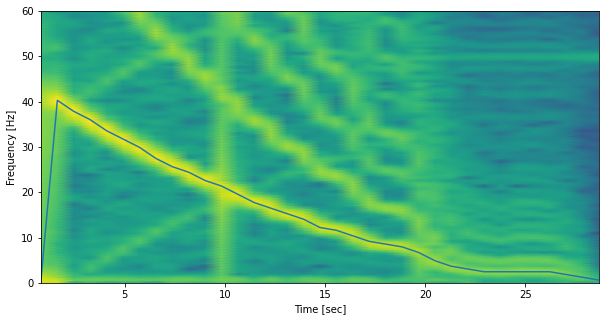

In [314]:
f, ax = plt.subplots(figsize = (10,5))
z = np.log(np.abs(Sxx))
ax.pcolormesh(St, Sf,  z, shading='gouraud')
ax.set(ylabel = 'Frequency [Hz]', xlabel = 'Time [sec]', ylim = (0,60))

freq_peak_index = np.argmax(Sxx, axis = 0)
freq_peak_f = Sf[freq_peak_index]
freq_peak_amplitude = np.take_along_axis(Sxx, freq_peak_index[None, :], axis = 0)
ax.plot(St, freq_peak_f)

In [257]:
print(np.shape(St), np.shape(Sf), np.shape(Sxx), np.shape(freq_peak_index[None, :]))
np.take_along_axis(Sxx, freq_peak_index[None, :], axis = 0)

(35,) (8193,) (8193, 35) (1, 35)


array([[3.01182091e+00, 1.27460302e+01, 1.14836931e+01, 9.31368592e+00,
        9.33967352e+00, 8.64549188e+00, 7.58266166e+00, 6.91380554e+00,
        5.74007506e+00, 4.93616114e+00, 5.44864947e+00, 3.63285329e+00,
        3.51169785e+00, 3.54337023e+00, 2.40221269e+00, 2.76567622e+00,
        1.89030467e+00, 1.55880276e+00, 1.55706811e+00, 9.24327159e-01,
        7.27608767e-01, 6.99616140e-01, 7.28009788e-01, 3.70781852e-01,
        1.75920996e-01, 9.32281530e-02, 4.57848536e-02, 4.55895281e-02,
        3.90718448e-02, 4.61319890e-02, 4.69486608e-02, 4.28252606e-02,
        2.16762686e-02, 4.45686733e-03, 3.18898588e-04]])

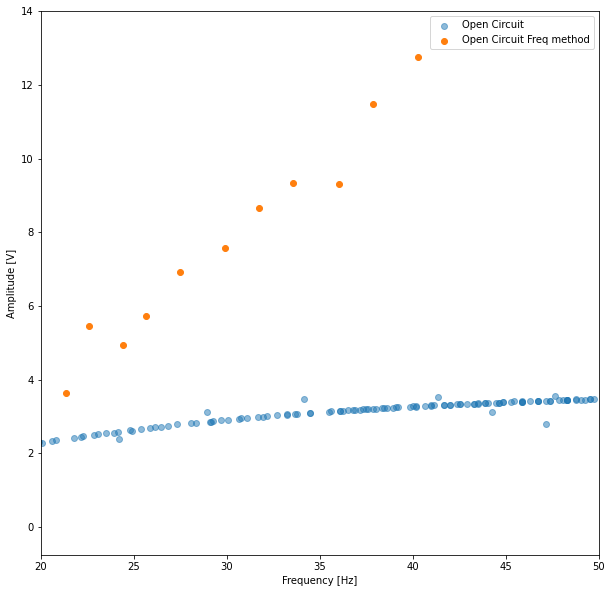

In [315]:
f, ax = plt.subplots(figsize = (10,10))
ax.scatter(freq, amplitudes, alpha = 0.5, label = "Open Circuit")
ax.scatter(freq_peak_f, freq_peak_amplitude, label = "Open Circuit Freq method")

ax.set(xlim = (20, 50), ylim = (None, 14),
       xlabel = "Frequency [Hz]", ylabel = "Amplitude [V]")
ax.legend()

[(6.0, 8.0)]

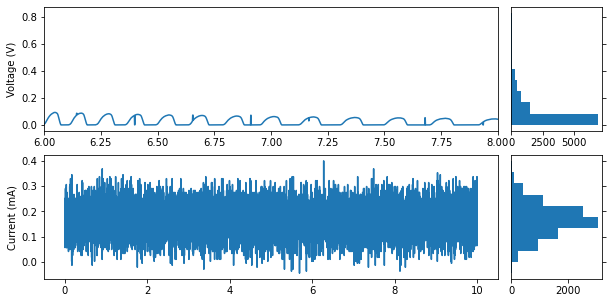

In [25]:
f, (axV, axI) = plot_samples(t, V,I)
axV.set(xlim = (6,8))


Requested 0.2kHz
Samples rate is 100000 samples per second
So freq equates to a period of 500 samples

10 time periods requested
so overall 5000 samples will be taken

Phase: 0.50 pi Amplitude: 0.50


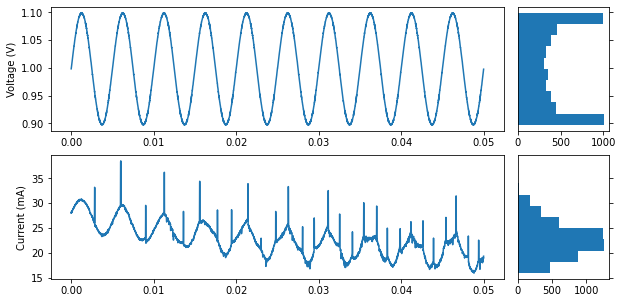

In [119]:
# mode = Mode.SVMI_SPLIT
mode = Mode.SVMI

freq = 200 # in Hz
sample_periods = 10
sample_time = sample_periods / freq
sample_time_in_samples = int(smu.sample_rate * sample_time)

period_in_samples = int((1 / freq) * smu.sample_rate)
print(f"""
Requested {freq/1e3}kHz
Samples rate is {smu.sample_rate} samples per second
So freq equates to a period of {period_in_samples} samples

{sample_periods} time periods requested
so overall {sample_time_in_samples} samples will be taken
""")

A = 100 / 1000
theta = np.linspace(0, 2*np.pi, period_in_samples) #in seconds
signal = 1 + A*np.sin(theta)

CHA.mode = mode
CHA.arbitrary(signal, cyclic = True)

t = np.linspace(0, sample_time, sample_time_in_samples)
V,I = np.array(CHA.get_samples(sample_time_in_samples)).T

theta = np.linspace(0, 2*np.pi*sample_periods, sample_time_in_samples)
z = np.exp(theta*1j)
s = sum(z*V)/ A / sample_time_in_samples
print(f"Phase: {np.angle(s)/np.pi:.2f} pi Amplitude: {np.abs(s):.2f}")

f, (axV, axI) = plot_samples(t,V,I)
axV.plot(t, 2.5 + np.real(z))
axV.plot(t, 2.5 + np.imag(z))

In [107]:
def sweep_frequency(fs, A = 0.1,
                    mode = Mode.SVMI, sample_periods = 10):
    smu.set_led(0b100) #blue led on
    CHA.constant(value = 0)
    CHA.mode = mode
    values = []
    
    try:
        red = True
        for freq in fs:
            sample_time = sample_periods / freq
            sample_time_in_samples = int(smu.sample_rate * sample_time)
            period_in_samples = int((1 / freq) * smu.sample_rate)

            theta = np.linspace(0, 2*np.pi, period_in_samples) #in seconds
            signal = 2.5 + A*np.sin(theta)

            CHA.mode = mode
            CHA.arbitrary(signal, cyclic = True)

            t = np.linspace(0, sample_time, sample_time_in_samples)
            V,I = np.array(CHA.get_samples(sample_time_in_samples)).T

            theta = np.linspace(0, 2*np.pi*sample_periods, sample_time_in_samples)
            z = np.exp(theta*1j)
            s = sum(z*V)/ A / sample_time_in_samples
            values.append(s)
        return np.array(values)
    
    finally:
        CHA.mode = Mode.HI_Z
        smu.set_led(0b000) #blue led off 
        
fs = np.geomspace(500, 10e3, 50)     
A = sweep_frequency(fs, A = 1, mode = Mode.SVMI_SPLIT)

[None]

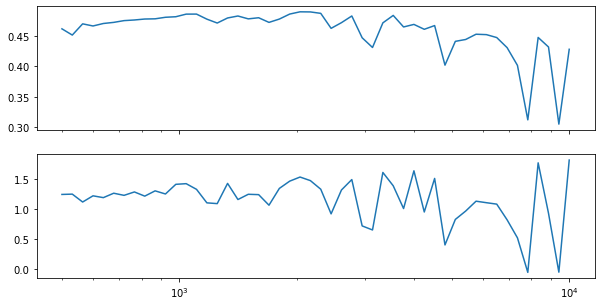

In [108]:
a = np.abs(A)
p = np.angle(A)

f, axes = plt.subplots(nrows = 2, figsize = (10,5), sharex = 'col')
axes[0].plot(fs, a)
axes[1].plot(fs, p)
axes[0].set(xscale = 'log')
axes[1].set(xscale = 'log')

<ErrorbarContainer object of 3 artists>

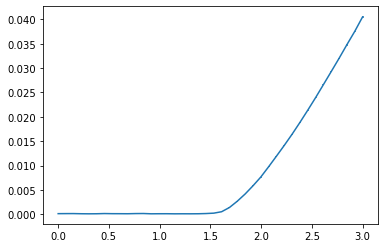

In [6]:
Vs = np.linspace(0, 3, 40)

def sweepV(Vs, settle_time = 0.0, n_samples = 10):
    smu.set_led(0b100) #blue led on
    CHA.constant(value = 0)
    CHA.mode = Mode.SVMI
    time.sleep(0.2)
    try:
        red = True
        for V in Vs:
            CHA.constant(value = V)
            time.sleep(settle_time)
            smu.set_led(0b100 + 0b001 * red)
            red = not red

            V, I = np.array(CHA.get_samples(n_samples)).T
            if abs(np.mean(I)) > 0.2: return #bail if we get to peak current

            V, dV = np.mean(V), scipy.stats.sem(V)
            I, dI = np.mean(I), scipy.stats.sem(I)
            yield V, dV, I, dI
    
    finally:
        CHA.mode = Mode.HI_Z
        smu.set_led(0b000) #blue led off 

V, dV, I, dI = np.array(list(sweepV(Vs))).T
plt.errorbar(V, I, dI)

In [14]:
smu.default_rate

100000

<ErrorbarContainer object of 3 artists>

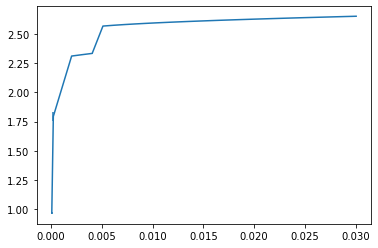

In [18]:
Is = np.linspace(0, 30 / 1000, 30)

def sweepI(Is, settle_time = 0.05, n_samples = 100):
    smu.set_led(0b100) #blue led on
    CHA.constant(value = 0)
    CHA.mode = Mode.SIMV
    CHA.get_samples(n_samples) #dummy read seems to help initialisation
    try:
        red = True
        for I in Is:
            CHA.constant(value = I)
            smu.set_led(0b100 + 0b001 * red)
            red = not red

            V, I = np.array(CHA.get_samples(n_samples)).T
            if abs(np.mean(I)) > 0.2: return #bail if we get to peak current

            V, dV = np.mean(V), scipy.stats.sem(V)
            I, dI = np.mean(I), scipy.stats.sem(I)
            yield V, dV, I, dI
    
    finally:
        CHA.mode = Mode.HI_Z
        smu.set_led(0b000) #blue led off 

V, dV, I, dI = np.array(list(sweepI(Is))).T
plt.errorbar(I, V, dV)

In [34]:
CHA.mode = Mode.SIMV
CHA.constant(value = 0.9 / 1000)
CHA.get_samples(100000);

In [32]:
np.array(smu.get_samples(10))[:, channel]

(10, 2, 2)

In [12]:
from jupyterplot import ProgressPlot

pp = ProgressPlot(plot_names=["Voltage", "Current"],
                  line_names=["A", "B"])

for i in range(100):
    samples = np.array(smu.get_samples(10))
    means = np.mean(samples, axis = 0)
    sems = scipy.stats.sem(samples, axis = 0)
    V, I = means.T
    dV, dI = sems.T
    pp.update([list(V), list(I)])
    time.sleep(0.1)
    
    
pp.finalize()

In [49]:
pp = ProgressPlot(plot_names=["Voltage", "Current"],
                  line_names=["A", "B"])

# pp._settings['xAxisConfig']['limit']

ValueError: xaxis_config["limit"] must be a list with length two

In [ ]:
''' SMU Voltage Range Settings 'from low to hi" USER can set in range from -5V to +5V'''
lowVolt = -5
hiVolt =  5
precision = .1
''' 1.0, 0.10 or 0.01 the number of decimal placees--will affect number of samples'''
   
 
''' convert volt range for greater precision'''
lowVolt = int((lowVolt)/precision)
hiVolt = int((hiVolt)/precision+1)
session = pysmu.Session(ignore_dataflow=True)
print(session)

smu = session.devices[0]
#smu = list_devices(session,0) more debug
print (smu.serial)
print (smu.fwver)

''' Set both channels to SMU mode. (different settings, just FYI'''
chan_a = smu.channels['A']
chan_b = smu.channels['B']

# CHAN_A source
chan_a.mode = Mode.HI_Z
# chan_a.mode = Mode.SVMI
#chan_a.mode = Mode.SVMI_SPLIT
#chan_a.mode = Mode.SIMV
# CHAN_B source
chan_b.mode = Mode.HI_Z
# chan_b.mode = Mode.SVMI
#chan_b.mode = Mode.SIMV
#chan_b.mode = Mode.SIMV_SPLIT

'''this sends settings to ADALM1000'''
def out_file(v_a,v_b):
    #print (volt)
    session.start(0)
    chan_a.constant(v_a)
    chan_b.constant(v_b)
    #if v_b == 5: debug
    time.sleep(2)
    amps = QM()   
    time.sleep(0)
    volt = v_a - v_b
    data = ()
    for x in smu.read(1):   
        out_data = ((x[0][0], x[0][1], x[1][0], x[1][1]))
        data = (str(out_data).replace('(',''))
        time.sleep(.1)
        if len(data) > 0:
            print (str(round(volt,2)) + ', ' + str(amps)+', '+ str(data.replace(')','')))
            file.write(str(round(volt,2)) +', ' + str(amps) +', ' + str(data).replace(')','')+'\n')

# deal with negative voltage
if lowVolt < 0 and hiVolt > 0:
    for vb in range(abs(lowVolt),0,-1):   
        v_a = 0.0
        v_b = float(vb*precision)
        out_file(v_a,v_b)
    for va in range(0,hiVolt):
        v_a = float(va*precision)
        v_b = 0.0
        out_file(v_a,v_b)
else:       
    for va in range(lowVolt,hiVolt): # when both lowVolt and hiVolt > 0
        v_a = float(va*precision)
        v_b = 0.0
        out_file(v_a,v_b)
   
# deal with both lowVolt and hiVolt negative voltage
if lowVolt < 0 and hiVolt < 0:
    for vb in range((lowVolt),abs(hiVolt),-1):   
        v_a = 0.0
        v_b = float(vb*precision)
        out_file(v_a,v_b)
       
    for va in range((hiVolt),(lowVolt)):
        v_a = float(va*precision)
        v_b = 0.0
        out_file(v_a,v_b)   

'''DONE, tidy up''' 
file.close()
chan_a.mode = Mode.HI_Z
chan_b.mode = Mode.HI_Z
chan_a.constant(0)
chan_b.constant(0)
#print (All finished")